# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [13]:
from collections import deque
from ddpg_agent import Agent
import torch
import random


num_episodes=10000
episode_scores = []
average_scores = []
scores_average_window = 100      
solved_score = .60     #(sloved score is 0.5; I set it higher here to achive more robust end-sate performance)


In [14]:
agent_1 = Agent(state_size=48, action_size=action_size, num_agents=1, random_seed=0)
agent_2 = Agent(state_size=48, action_size=action_size, num_agents=1, random_seed=0)

In [15]:
for i_episode in range(1, num_episodes+1):

    # reset the unity environment at the beginning of each episode
    env_info = env.reset(train_mode=True)[brain_name]     

    # get initial state of the unity environment 
    states = env_info.vector_observations
    states = np.reshape(states, (1, 48)) # reshape so we can feed both agents states to each agent
 
    # reset each agent for a new episode
    agent_1.reset()
    agent_2.reset()

    # set the initial episode score to zero.
    agent_scores = np.zeros(num_agents)

    # Run the episode training loop;
    # At each loop step take an action as a function of the current state observations
    # Based on the resultant environmental state (next_state) and reward received update the Agents Actor and Critic networks
    # If environment episode is done, exit loop...
    # Otherwise repeat until done == true 
    while True:
        # determine actions for the unity agents from current sate, using noise for exploration
        actions_1 = agent_1.act(states, add_noise=True)
        actions_2 = agent_2.act(states, add_noise=True)

        # send the actions to the unity agents in the environment and receive resultant environment information
        actions = np.concatenate((actions_1, actions_2), axis=0) 
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]

        next_states = env_info.vector_observations   # get the next states for each unity agent in the environment
        next_states = np.reshape(next_states, (1, 48))
        rewards = env_info.rewards                   # get the rewards for each unity agent in the environment
        dones = env_info.local_done                  # see if episode has finished for each unity agent in the environment

        #Send (S, A, R, S') info to the training agent for replay buffer (memory) and network updates
        agent_1.step(states, actions_1, rewards[0], next_states, dones[0])
        agent_2.step(states, actions_2, rewards[1], next_states, dones[1])

        # set new states to current states for determining next actions
        states = next_states
        #print(states)
        # Update episode score for each unity agent
        agent_scores += rewards

        # If any unity agent indicates that the episode is done, 
        # then exit episode loop, to begin new episode
        if np.any(dones):
            break

    # Add episode score to Scores and...
    # Calculate mean score over last 100 episodes 
    # Mean score is calculated over current episodes until i_episode > 100
    episode_scores.append(np.max(agent_scores))
    average_score = np.mean(episode_scores[i_episode-min(i_episode,scores_average_window):i_episode+1])
    average_scores.append(average_score)
    #Print current and average score
    if i_episode % 100 == 0:
        print('\nEpisode {}\tMax Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, episode_scores[i_episode-1], average_score), end="")
    
    # Save trained  Actor and Critic network weights for agent 1
    an_filename = "ddpgActor1_Model.pth"
    torch.save(agent_1.actor_local.state_dict(), an_filename)
    cn_filename = "ddpgCritic1_Model.pth"
    torch.save(agent_1.critic_local.state_dict(), cn_filename)

    # Save trained  Actor and Critic network weights for agent 2
    an_filename = "ddpgActor2_Model.pth"
    torch.save(agent_2.actor_local.state_dict(), an_filename)
    cn_filename = "ddpgCritic2_Model.pth"
    torch.save(agent_2.critic_local.state_dict(), cn_filename)

    # Check to see if the task is solved (i.e,. avearge_score > solved_score over 100 episodes). 
    # If yes, save the network weights and scores and end training.
    if i_episode > 100 and average_score >= solved_score:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))

        # Save the recorded Scores data
        scores_filename = "ddpgAgent_Scores.csv"
        np.savetxt(scores_filename, episode_scores, delimiter=",")
        break



Episode 100	Max Score: 0.00	Average Score: 0.00
Episode 200	Max Score: 0.00	Average Score: 0.00
Episode 300	Max Score: 0.00	Average Score: 0.01
Episode 400	Max Score: 0.00	Average Score: 0.01
Episode 500	Max Score: 0.10	Average Score: 0.02
Episode 600	Max Score: 0.09	Average Score: 0.07
Episode 700	Max Score: 0.10	Average Score: 0.09
Episode 800	Max Score: 0.10	Average Score: 0.16
Episode 900	Max Score: 0.10	Average Score: 0.26
Episode 1000	Max Score: 0.10	Average Score: 0.18
Episode 1100	Max Score: 0.00	Average Score: 0.24
Episode 1200	Max Score: 2.30	Average Score: 0.43
Episode 1300	Max Score: 0.10	Average Score: 0.29
Episode 1400	Max Score: 0.40	Average Score: 0.30
Episode 1500	Max Score: 0.30	Average Score: 0.50
Episode 1600	Max Score: 0.30	Average Score: 0.48
Environment solved in 1634 episodes!	Average Score: 0.60


In [17]:
np.save('./episode_scores', episode_scores)

In [18]:
np.save('./average_scores', average_scores)

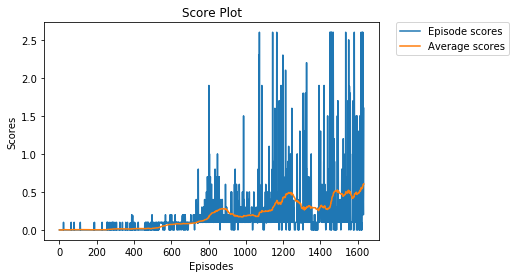

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(episode_scores, label = 'Episode scores')
plt.plot(average_scores, label = 'Average scores')
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.title('Score Plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [ ]:
#Initialize Agent
agent_1 = Agent(state_size=48, action_size=action_size, num_agents=1, random_seed=0)
agent_2 = Agent(state_size=48, action_size=action_size, num_agents=1, random_seed=0)

# Load trained model weights for agent 1
agent_1.actor_local.load_state_dict(torch.load('ddpgActor1_Model.pth'))
agent_1.critic_local.load_state_dict(torch.load('ddpgCritic1_Model.pth'))

# Load trained model weights for agent 2
agent_2.actor_local.load_state_dict(torch.load('ddpgActor2_Model.pth'))
agent_2.critic_local.load_state_dict(torch.load('ddpgCritic2_Model.pth'))


In [ ]:
for i_episode in range(1, num_episodes+1):

    # reset the unity environment at the beginning of each episode
    # set train mode to false
    env_info = env.reset(train_mode=False)[brain_name]     

    # get initial state of the unity environment 
    states = env_info.vector_observations
    states = np.reshape(states, (1, 48))  # reshape so we can feed both agents states to each agent

    # reset the training agent for new episode
    agent_1.reset()
    agent_2.reset()

    # set the initial episode scores to zero for each unity agent.
    agent_scores = np.zeros(num_agents)

    # Run the episode loop;
    # At each loop step take an action as a function of the current state observations
    # If environment episode is done, exit loop...
    # Otherwise repeat until done == true 
    while True:
        # determine actions for the unity agents from current sate
        actions_1 = agent_1.act(states, add_noise=False)
        actions_2 = agent_2.act(states, add_noise=False)

        # send the actions to the unity agents in the environment and receive resultant environment information
        actions = np.concatenate((actions_1, actions_2), axis=0) 
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]

        next_states = env_info.vector_observations   # get the next states for each unity agent in the environment
        next_states = np.reshape(next_states, (1, 48))
        rewards = env_info.rewards                   # get the rewards for each unity agent in the environment
        dones = env_info.local_done                  # see if episode has finished for each unity agent in the environment

        # set new states to current states for determining next actions
        states = next_states

        # Update episode score for each unity agent
        agent_scores += rewards

        # If any unity agent indicates that the episode is done, 
        # then exit episode loop, to begin new episode
        if np.any(dones):
            break

    # Print current average score
    if i_episode % 100 == 0:
        print('\nEpisode {}\tAgent1 Score: {:.2f}\tAgent2 Score: {:.2f}'.format(i_episode, agent_scores[0], agent_scores[1], end=""))
